# Project 1 Code
## Alexander Wikner
### Begin by importing necessary python modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from CG import CG
from ASM import ASM
from SINewton import SINewton
from FindInitGuess import FindInitGuess
from SG import SG
from SLBFGS import SLBFGS
import sys
import os

Load in the data from the Project1 folder and display 2016 election data

In [2]:
path_parent = os.path.dirname(os.getcwd())
filepath = path_parent + '/Project1/'
df_2016 = pd.read_csv(filepath+'A2016.csv').dropna(axis = 0)
df_2012 = pd.read_csv(filepath+'A2012.csv').dropna(axis = 0)
print(df_2016)

       FIPS                 County      DEM      GOP  MedianIncome  MigraRate  \
0      1001     Autauga County, AL   5908.0  18110.0       54487.0        5.3   
1      1003     Baldwin County, AL  18409.0  72780.0       56460.0       21.5   
2      1005     Barbour County, AL   4848.0   5431.0       32884.0      -18.2   
3      1007        Bibb County, AL   1874.0   6733.0       43079.0       -0.8   
4      1009      Blount County, AL   2150.0  22808.0       47213.0       -1.0   
...     ...                    ...      ...      ...           ...        ...   
3138  56037  Sweetwater County, WY   3233.0  12153.0       74546.0      -17.9   
3139  56039       Teton County, WY   7313.0   3920.0       84118.0       -0.5   
3140  56041       Uinta County, WY   1202.0   6154.0       64713.0      -11.3   
3141  56043    Washakie County, WY    532.0   2911.0       49533.0      -15.2   
3142  56045      Weston County, WY    294.0   2898.0       56582.0        1.4   

      BirthRate  DeathRate 

Get data from only California and obtain indices for counties with more Democratic or Republican voters.

In [3]:
Cali_data = df_2016[df_2016['County'].str.contains(', CA')]
n, dim = Cali_data.shape
idem = np.where(Cali_data['DEM'] >= Cali_data['GOP'])
irep = np.where(Cali_data['DEM'] < Cali_data['GOP'])
num = Cali_data['DEM'] + Cali_data['GOP']
label = np.zeros(n)
label[idem] = -1
label[irep] = 1

Choose our 3 feature vectors (MedianIncome, BachelorRate, and log(NumVoters)) and display the data

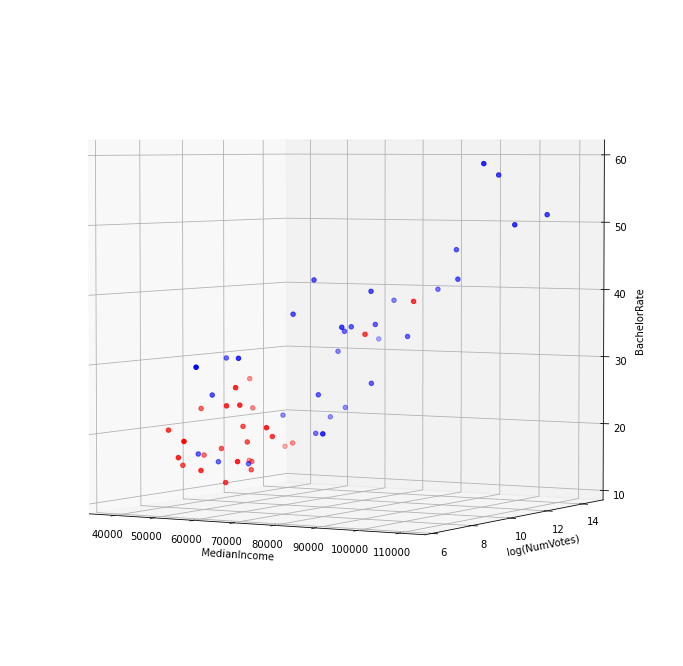

In [4]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
X  = Cali_data.iloc[:,4:]
X['log(NumVotes)'] = np.log(num)
i1, i2, i3 = (0,6,4)
ax.scatter(X.iloc[idem].iloc[:,i1],X.iloc[idem].iloc[:,i2],X.iloc[idem].iloc[:,i3],c = 'b')
ax.scatter(X.iloc[irep].iloc[:,i1],X.iloc[irep].iloc[:,i2],X.iloc[irep].iloc[:,i3],c = 'r')
ax.view_init(3)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.show()

Normalize each of the variables to be between 0 and 1 using sklearn and plot the resulting data

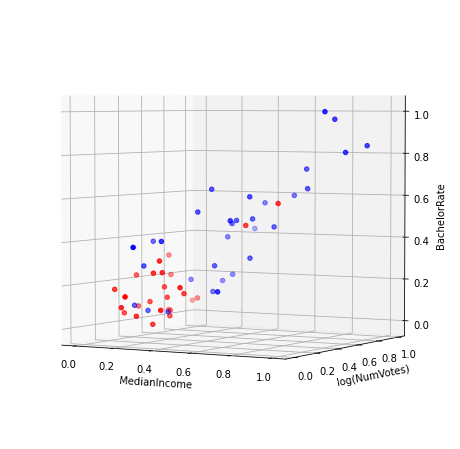

In [5]:
fig2 = plt.figure(figsize = (8,8))
ax = fig2.add_subplot(111, projection='3d')
XX = X.iloc[:,[i1,i2,i3]].values
min_max_scaler = preprocessing.MinMaxScaler()
XX = min_max_scaler.fit_transform(XX)
ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
ax.view_init(3)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.show()

## Question 1
### I begin by setting up the SVN mimization problem using the log-likelihood loss function

In [6]:
(n, dim) = XX.shape
lam = 0.01
Y = np.outer(label,np.ones(dim+1)) * np.concatenate((XX,np.ones((n,1))),axis = 1)
w0 = np.array([-1,-1,1,1])

def fun0(I,Y,w,lam):
    f = np.sum(np.log(1 + np.exp(-Y[I,:] @ w)))/len(I) + 0.5*lam*np.dot(w,w)
    return f

def gfun0(I,Y,w,lam):
    aux = np.exp(-Y[I,:] @ w)
    d1 = Y.shape[1]
    g = np.sum(-Y[I,:] * (np.outer((aux/(1 + aux)),np.ones(d1))), axis = 0)/len(I) + lam*w
    return g

def Hvec0(I,Y,w,v,lam):
    aux = np.exp(-Y[I,:] @ w)
    d1 = Y.shape[1]
    Hv = np.sum(Y[I,:] * np.outer((aux * (Y[I,:] @ v)/(np.power((1+aux),2))),np.ones(d1)), axis = 0) + lam*v
    return Hv

fun = lambda I,Y,w: fun0(I,Y,w,lam)
gfun = lambda I,Y,w: gfun0(I,Y,w,lam)
Hvec = lambda I,Y,w,v: Hvec0(I,Y,w,v,lam)

I solve for the plane that minimizes this loss function using stochastic Inexact Newton's method and plot the resulting dividing plane as well as the loss function value and gradient norm value versus iteration.

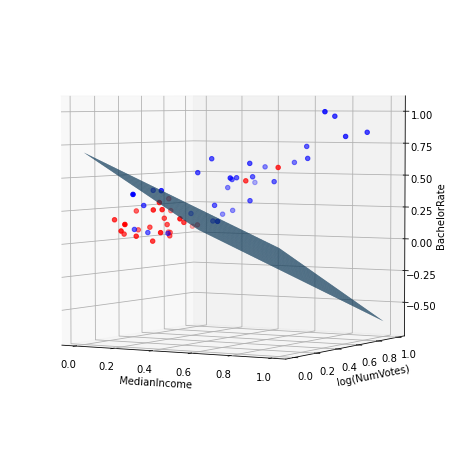

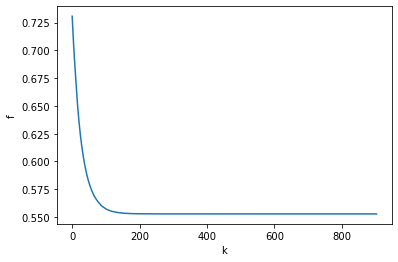

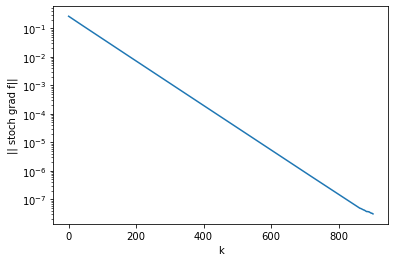

In [7]:
w,f,gnorm,runtime = SINewton(fun,gfun,Hvec,Y,w0)
wplotsvn = np.copy(w)
fig2 = plt.figure(figsize = (8,8))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
nn = 50
xx,yy = np.meshgrid(np.linspace(0,1,num=nn),np.linspace(0,1,num=nn))
zplot = (-w[0]*xx -w[1]*yy-w[3])/w[2]
ax.plot_surface(xx,yy,zplot)
ax.view_init(3)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.show()

plt.figure()
niter = len(f)
plt.plot(np.arange(niter),f)
plt.xlabel('k')
plt.ylabel('f')
plt.show()

plt.figure()
niter = len(gnorm)
plt.plot(np.arange(niter),gnorm)
plt.xlabel('k')
plt.ylabel('|| stoch grad f||')
plt.yscale('log')
plt.show()

### 1(a) Next, I set up the constrained minimization problem with soft boundaries to be solved with the Active Set Method. The loss function, gradient, and Hessian functions are obtained from Eq. 52-54 of the class notes. I then define a function that uses ReLU iteration to find a feasible initial guess that satisfies the problem constraints before running the ASM.

In [8]:
def fun0SB(x,d,C):
    M = np.eye(x.size)
    M[d:,d:] = 0.
    v = np.zeros(x.size)
    v[d+1:] = 1.
    f = 0.5*np.dot(x,M @ x) + C*np.dot(v,x)
    return f

def gfun0SB(x,d,C):
    g = np.copy(x)
    g[d] = 0
    g[d+1:] = C
    return g

def Hfun0SB(x,d,C):
    H = np.eye(x.size)
    H[d:,d:] = 0
    return H

def RunASMwSB(XX, Y, C = 1e3, itermax = 1000):
    # Finds an initial feasible point for the ASM and then runs the ASM
    #  XX - data matrix
    #  Y - target matrix
    #  C - weight assigned to penalty variables for soft boundaries
    d = XX.shape[1]
    n = XX.shape[0]
    funSB = lambda x: fun0SB(x,d,C)
    gfunSB = lambda x: gfun0SB(x,d,C)
    HfunSB = lambda x: Hfun0SB(x,d,C)
    
    # Form A and b matrices for the soft boundaries case
    b = np.concatenate((np.ones(n),np.zeros(n)))
    At = np.concatenate((Y,np.eye(n)),axis = 1)
    Ab = np.concatenate((np.zeros((n,d+1)),np.eye(n)),axis = 1)
    A = np.concatenate((At,Ab))
    w = np.array([-1,-1,1,1])
    Aguess = Y
    bguess = np.ones(n)
    # Use gradient descent with ReLU to find an initial guess for the 
    # dividing plane weights and penalty variables
    w, l, lcomp = FindInitGuess(w,Aguess,bguess)
    winit = np.append(w,lcomp)
    x, l2, lcom2 = FindInitGuess(winit, A, b)
    # print(l2)
    # Determine active constraints
    W = np.where(A @ x == 0)[0]
    # Run Active Set Method
    xiter, lm, runtime = ASM(x, gfunSB, HfunSB, A, b, W, itermax = itermax)
    return xiter, lm, runtime

I run the Active Set Method and plot the resulting hyperplane as well as the hyperplane found from using the unconstrained log-loss function and SINewton. While both of these planes look quite reasonable, it appears that the plane found by the Active Set Method looks more reasonable.

A local solution is found, iter = 38



/Users/Alexander_1/miniconda3/envs/reservoir-rls-numba/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1642: ComplexWarning: Casting complex values to real discards the imaginary part
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/Users/Alexander_1/miniconda3/envs/reservoir-rls-numba/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1643: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/Users/Alexander_1/miniconda3/envs/reservoir-rls-numba/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


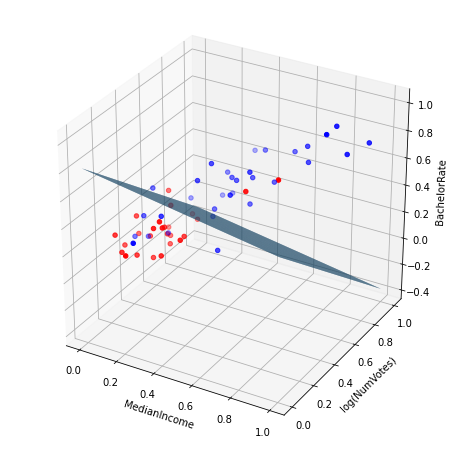

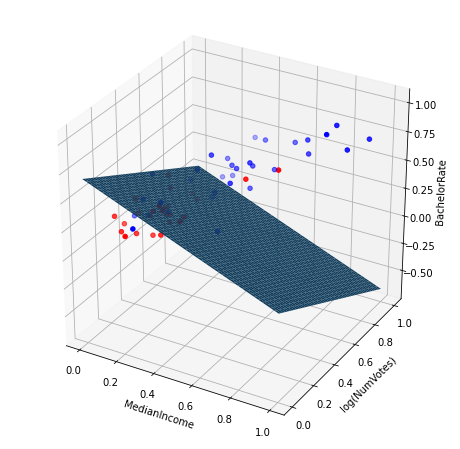

In [9]:
xiter, lm, runtimeASM = RunASMwSB(XX, Y)
wplot = xiter[-1,:4]
fig2 = plt.figure(figsize = (8,8))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
nn = 50
xx,yy = np.meshgrid(np.linspace(0,1,num=nn),np.linspace(0,1,num=nn))
zplot = (-wplot[0]*xx -wplot[1]*yy-wplot[3])/wplot[2]
ax.plot_surface(xx,yy,zplot)
ax.view_init(30)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.show()


fig2 = plt.figure(figsize = (8,8))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
nn = 50
xx,yy = np.meshgrid(np.linspace(0,1,num=nn),np.linspace(0,1,num=nn))
zplot = (-wplotsvn[0]*xx -wplotsvn[1]*yy-wplotsvn[3])/wplotsvn[2]
ax.plot_surface(xx,yy,zplot)
ax.view_init(30)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.show()

### 1(b) Next, I extract data from multiple Democratically dominated states and attempt to find the hyperplane between the Democratic and Republican counties using the previously mentioned features (MedianIncome, BachelorRate, log(NumVoters)). I compare the hyperplanes found by using the log-likelihood loss function and SINewton and the contrained minimization problem with soft margins and ASM. I additionally plot the total runtime, and note that the runtime for the ASM increases much more dramatically as the data size increases than does that for SINewton. I thus conclude that it is better to switch to the unconstrained minimization problem due to its better scalability. 

A local solution is found, iter = 114



/Users/Alexander_1/miniconda3/envs/reservoir-rls-numba/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1642: ComplexWarning: Casting complex values to real discards the imaginary part
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/Users/Alexander_1/miniconda3/envs/reservoir-rls-numba/lib/python3.7/site-packages/mpl_toolkits/mplot3d/axes3d.py:1643: ComplexWarning: Casting complex values to real discards the imaginary part
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/Users/Alexander_1/miniconda3/envs/reservoir-rls-numba/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


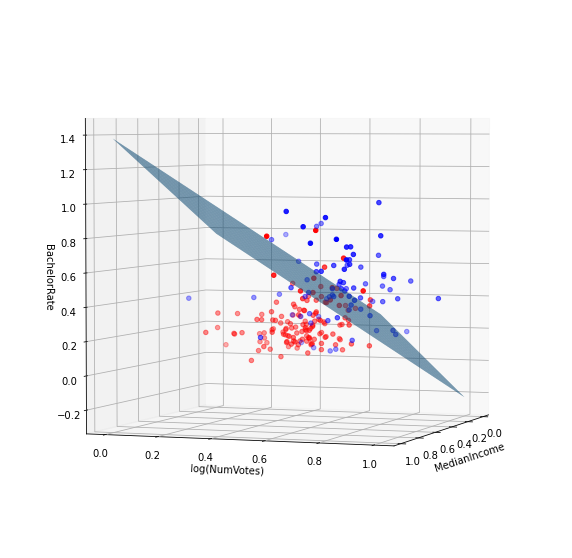

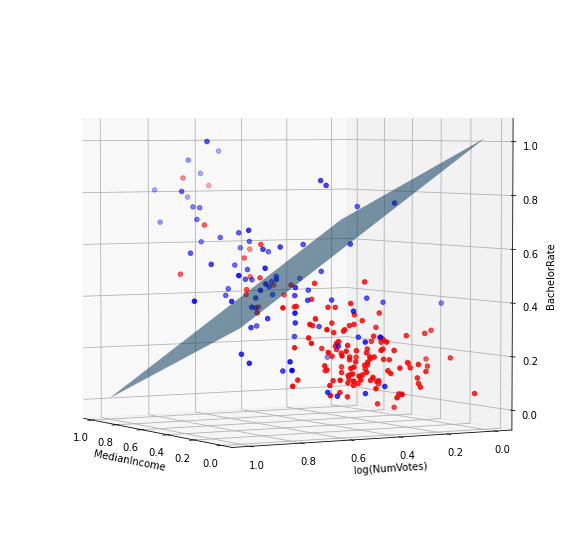

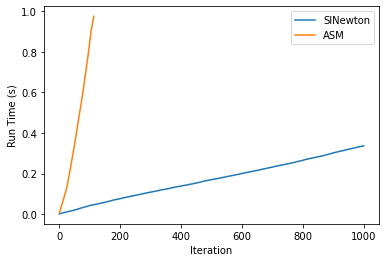

In [46]:
# searchfor = [', CA']
# searchfor = [', CA', ', OR']  # Uncomment each of these lines to test each method with different data sets.
# searchfor = [', CA', ', OR', ', WA']
# searchfor = [', CA', ', OR', ', WA',', NJ']
searchfor = [', CA', ', OR', ', WA',', NJ',', NY']
data = df_2016[df_2016['County'].str.contains('|'.join(searchfor))]
n, dim = data.shape
idem = np.where(data['DEM'] >= data['GOP'])
irep = np.where(data['DEM'] < data['GOP'])
num = data['DEM'] + data['GOP']
label = np.zeros(n)
label[idem] = -1
label[irep] = 1
X  = data.iloc[:,4:]
X['log(NumVotes)'] = np.log(num)
i1, i2, i3 = (0,6,4)
XX = X.iloc[:,[i1,i2,i3]].values
min_max_scaler = preprocessing.MinMaxScaler()
XX = min_max_scaler.fit_transform(XX)
n, dim = XX.shape
lam = 0.01
Y = np.outer(label,np.ones(dim+1)) * np.concatenate((XX,np.ones((n,1))),axis = 1)
w = np.array([-1,-1,1,1])

wplotsvn,f,gnorm, runtime = SINewton(fun,gfun,Hvec,Y,w)
runtime = runtime[np.where(runtime!=0)]
xiter, lm, runtimeASM = RunASMwSB(XX,Y,C = 1e3)

wplot = xiter[-1,:4]

fig2 = plt.figure(figsize = (10,10))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
nn = 50
xx,yy = np.meshgrid(np.linspace(0,1,num=nn),np.linspace(0,1,num=nn))
zplot = (-wplot[0]*xx -wplot[1]*yy-wplot[3])/wplot[2]
ax.plot_surface(xx,yy,zplot,alpha = 0.7)
ax.view_init(3,20)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.savefig('SINewton_dividingplane_%dstates.png' % len(searchfor),transparent = True,bbox_inches = 'tight')
plt.show()


fig2 = plt.figure(figsize = (10,10))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
nn = 50
xx,yy = np.meshgrid(np.linspace(0,1,num=nn),np.linspace(0,1,num=nn))
zplot = (-wplotsvn[0]*xx -wplotsvn[1]*yy-wplotsvn[3])/wplotsvn[2]
ax.plot_surface(xx,yy,zplot,alpha = 0.7)
ax.view_init(3,150)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.savefig('ASMwSB_dividingplane_%dstates.png' % len(searchfor),transparent = True,bbox_inches = 'tight')
plt.show()

fig2 = plt.figure()
plt.plot(np.arange(1,len(runtime)+1),runtime, label = 'SINewton')
plt.plot(np.arange(1,len(runtimeASM)+1), runtimeASM, label = 'ASM')
plt.xlabel('Iteration')
plt.ylabel('Run Time (s)')
plt.legend()
plt.savefig('ASMwSB_vs_SINewton_runtimes_%dstates.png' % len(searchfor),transparent = True,bbox_inches = 'tight')
plt.show()

## Question 2
### I first extract all of the democratic counties and an equal number of randomly chosen republican counties from the data set. I then fit this data such that each of the chosen feature values are between [0,1].

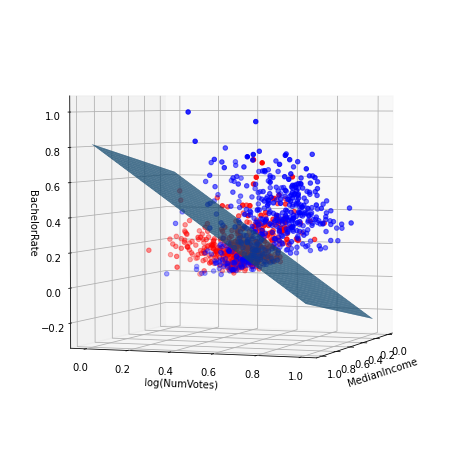

In [74]:
idem = np.where(df_2016['DEM'] >= df_2016['GOP'])[0]
repmask = np.ones(df_2016.shape[0])
repmask[idem] = 0
repmask = np.array(repmask, dtype = bool)
rep_data = df_2016.iloc[repmask]
dem_data = df_2016.iloc[idem,:]
np.random.seed(10)
rand_rep_counties = np.random.permutation(rep_data.shape[0])[:len(idem)]
rep_data = rep_data.iloc[rand_rep_counties,:]
data = dem_data.append(rep_data)
n = data.shape[0]
idem = np.where(data['DEM'] >= data['GOP'])
irep = np.where(data['DEM'] < data['GOP'])
num = data['DEM'] + data['GOP']
label = np.zeros(n)
label[idem] = -1
label[irep] = 1
X  = data.iloc[:,4:]
X['log(NumVotes)'] = np.log(num)
i1, i2, i3 = (0,6,4)
XX = X.iloc[:,[i1,i2,i3]].values
min_max_scaler = preprocessing.MinMaxScaler()
XX = min_max_scaler.fit_transform(XX)
(n, dim) = XX.shape
Y = np.outer(label,np.ones(dim+1)) * np.concatenate((XX,np.ones((n,1))),axis = 1)
w = np.array([-1,-1,1,1])

wplotsvn,f,gnorm, runtime = SINewton(fun,gfun,Hvec,Y,w)


fig2 = plt.figure(figsize = (8,8))
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
nn = 50
xx,yy = np.meshgrid(np.linspace(0,1,num=nn),np.linspace(0,1,num=nn))
zplot = (-wplotsvn[0]*xx -wplotsvn[1]*yy-wplotsvn[3])/wplotsvn[2]
ax.plot_surface(xx,yy,zplot)
ax.view_init(3,20)
ax.set_xlabel(X.columns[i1])
ax.set_ylabel(X.columns[i2])
ax.set_zlabel(X.columns[i3])
plt.show()

### Here, I define the function for each strategy for choosing step size during stochastic gradient descent. I try 3 strategies: a constant step size, a harmonically decreasing step size, and a step size that decreases by half on a schedule such that the convergence requirements for SGD are satisfied.

In [12]:
def aconst0(itr, a):
    return a

def aitr(itr):
    return 1/(itr+1)

def ahalf0(itr, m0, a):
    if itr < m0:
        return a
    elif itr >= m0 and itr < 2*m0:
        return a/2
    else:
        red_itr = itr - 2*m0
        kitr = 2
        ksum = 2**kitr/kitr
        while red_itr >= ksum:
            kitr += 1
            ksum += 2**kitr/kitr
        return 2**(-kitr)*a

I next perform SGD using the previous 3 strategies, using various values for step size and initial step size as well as the stochastic batch size. I additionally experiment with different values of $\lambda$.

In [25]:
maxiter = 3000
trials = 1000
a_vals = np.logspace(-2,1,4)
lams = np.array([1e-2])
m0 = 10
batchsizes = np.array([16,32,64,128,256])
from tqdm import tqdm
getdata = False

if getdata:
    total_iters = len(lams)*len(a_vals)*len(batchsizes)*trials*2 + len(lams)*len(batchsizes)*trials
    
    fmat = np.zeros((trials,maxiter+1,len(lams),len(a_vals),len(batchsizes)))
    gradnormmat = np.zeros((trials,maxiter+1,len(lams),len(a_vals),len(batchsizes)))
    xfin = np.zeros((trials,w.size,len(lams),len(a_vals),len(batchsizes)))
    runtime = np.zeros((trials,maxiter,len(lams),len(a_vals),len(batchsizes)))

    fmathalf = np.zeros((trials,maxiter+1,len(lams),len(a_vals),len(batchsizes)))
    gradnormmathalf = np.zeros((trials,maxiter+1,len(lams),len(a_vals),len(batchsizes)))
    xfinhalf = np.zeros((trials,w.size,len(lams),len(a_vals),len(batchsizes)))
    runtimehalf = np.zeros((trials,maxiter,len(lams),len(a_vals),len(batchsizes)))

    fmatitr = np.zeros((trials,maxiter+1,len(lams),len(batchsizes)))
    gradnormmatitr = np.zeros((trials,maxiter+1,len(lams),len(batchsizes)))
    xfinitr = np.zeros((trials,w.size,len(lams),len(batchsizes)))
    runtimeitr = np.zeros((trials,maxiter,len(lams),len(batchsizes)))
    with tqdm(total = total_iters) as pbar:
        for i in range(len(lams)):

            fun = lambda I,Y,w: fun0(I,Y,w,lams[i])
            gfun = lambda I,Y,w: gfun0(I,Y,w,lams[i])
            Hvec = lambda I,Y,w,v: Hvec0(I,Y,w,v,lams[i])

            for j in range(len(a_vals)):
                aconst = lambda itr: aconst0(itr,a_vals[j])
                ahalf = lambda itr: ahalf0(itr, m0, a_vals[j])
                if j == 0:
                    for k in range(len(batchsizes)):
                        for l in range(trials):
                            xiter, fmat[l,:,i,j,k], gradnormmat[l,:,i,j,k], runtime[l, : ,i,j,k] \
                                = SG(fun, gfun, Y, w, aconst,batchsize = batchsizes[k], itermax = maxiter)
                            xfin[l,:,i,j,k] = xiter[-1,:w.size]
                            pbar.update(1)
                            xiter, fmatitr[l,:,i,k], gradnormmatitr[l,:,i,k], runtimeitr[l,:,i,k] \
                                = SG(fun, gfun, Y, w, aitr,batchsize = batchsizes[k], itermax = maxiter)
                            xfinitr[l,:,i,k] = xiter[-1,:w.size]
                            pbar.update(1)
                            xiter, fmathalf[l,:,i,j,k], gradnormmathalf[l,:,i,j,k], runtimehalf[l,:,i,j,k]\
                                = SG(fun, gfun, Y, w, ahalf,batchsize = batchsizes[k], itermax = maxiter)
                            xfinhalf[l,:,i,j,k] = xiter[-1,:w.size]
                            pbar.update(1)
                        np.savetxt('Data/SG_fvals_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(fmat[:,:,i,j,k],axis = 0),delimiter = ',')
                        np.savetxt('Data/SG_fvals_k-1_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]), np.mean(fmatitr[:,:,i,k],axis = 0), delimiter = ',')
                        np.savetxt('Data/SG_fvals_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(fmathalf[:,:,i,j,k],axis = 0), delimiter = ',')
                        np.savetxt('Data/SG_gradnorm_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(gradnormmat[:,:,i,j,k],axis = 0),delimiter = ',')
                        np.savetxt('Data/SG_gradnorm_k-1_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]), np.mean(gradnormmatitr[:,:,i,k],axis = 0), delimiter = ',')
                        np.savetxt('Data/SG_gradnorm_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(gradnormmathalf[:,:,i,j,k],axis = 0), delimiter = ',')
                        np.savetxt('Data/SG_xfin_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), xfin[:,:,i,j,k],delimiter = ',')
                        np.savetxt('Data/SG_xfin_k-1_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]), xfinitr[:,:,i,k], delimiter = ',')
                        np.savetxt('Data/SG_xfin_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), xfinhalf[:,:,i,j,k], delimiter = ',')
                        np.savetxt('Data/SG_runtime_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(runtime[:,:,i,j,k],axis = 0),delimiter = ',')
                        np.savetxt('Data/SG_runtime_k-1_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]), np.mean(runtimeitr[:,:,i,k],axis = 0), delimiter = ',')
                        np.savetxt('Data/SG_runtime_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(runtimehalf[:,:,i,j,k],axis = 0), delimiter = ',')
                    #print(i,j,k)
                else:
                    for k in range(len(batchsizes)):
                        for l in range(trials):
                            xiter, fmat[l,:,i,j,k], gradnormmat[l,:,i,j,k], runtime[l, : ,i,j,k] \
                                = SG(fun, gfun, Y, w, aconst,batchsize = batchsizes[k], itermax = maxiter)
                            xfin[l,:,i,j,k] = xiter[-1,:w.size]
                            pbar.update(1)
                            xiter, fmathalf[l,:,i,j,k], gradnormmathalf[l,:,i,j,k], runtimehalf[l,:,i,j,k]\
                                = SG(fun, gfun, Y, w, ahalf,batchsize = batchsizes[k], itermax = maxiter)
                            xfinhalf[l,:,i,j,k] = xiter[-1,:w.size]
                            pbar.update(1)
                        np.savetxt('Data/SG_fvals_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(fmat[:,:,i,j,k],axis = 0),delimiter = ',')
                        np.savetxt('Data/SG_fvals_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(fmathalf[:,:,i,j,k],axis = 0), delimiter = ',')
                        np.savetxt('Data/SG_gradnorm_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(gradnormmat[:,:,i,j,k],axis = 0),delimiter = ',')
                        np.savetxt('Data/SG_gradnorm_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(gradnormmathalf[:,:,i,j,k],axis = 0), delimiter = ',')
                        np.savetxt('Data/SG_xfin_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), xfin[:,:,i,j,k],delimiter = ',')
                        np.savetxt('Data/SG_xfin_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), xfinhalf[:,:,i,j,k], delimiter = ',')
                        np.savetxt('Data/SG_runtime_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(runtime[:,:,i,j,k],axis = 0),delimiter = ',')
                        np.savetxt('Data/SG_runtime_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(runtimehalf[:,:,i,j,k],axis = 0), delimiter = ',')
                    #print(i,j,k)
    
    lams = np.array([1e-4,1e-2,1,100])
    a_vals = np.array([1])
    batchsizes = np.array([64])
    total_iters = len(lams)*len(a_vals)*len(batchsizes)*trials*2 + len(lams)*len(batchsizes)*trials
    
    fmat = np.zeros((trials,maxiter+1,len(lams),len(a_vals),len(batchsizes)))
    gradnormmat = np.zeros((trials,maxiter+1,len(lams),len(a_vals),len(batchsizes)))
    xfin = np.zeros((trials,w.size,len(lams),len(a_vals),len(batchsizes)))
    runtime = np.zeros((trials,maxiter,len(lams),len(a_vals),len(batchsizes)))

    fmathalf = np.zeros((trials,maxiter+1,len(lams),len(a_vals),len(batchsizes)))
    gradnormmathalf = np.zeros((trials,maxiter+1,len(lams),len(a_vals),len(batchsizes)))
    xfinhalf = np.zeros((trials,w.size,len(lams),len(a_vals),len(batchsizes)))
    runtimehalf = np.zeros((trials,maxiter,len(lams),len(a_vals),len(batchsizes)))

    fmatitr = np.zeros((trials,maxiter+1,len(lams),len(batchsizes)))
    gradnormmatitr = np.zeros((trials,maxiter+1,len(lams),len(batchsizes)))
    xfinitr = np.zeros((trials,w.size,len(lams),len(batchsizes)))
    runtimeitr = np.zeros((trials,maxiter,len(lams),len(batchsizes)))
    with tqdm(total = total_iters) as pbar:
        for i in range(len(lams)):

            fun = lambda I,Y,w: fun0(I,Y,w,lams[i])
            gfun = lambda I,Y,w: gfun0(I,Y,w,lams[i])
            Hvec = lambda I,Y,w,v: Hvec0(I,Y,w,v,lams[i])

            for j in range(len(a_vals)):
                aconst = lambda itr: aconst0(itr,a_vals[j])
                ahalf = lambda itr: ahalf0(itr, m0, a_vals[j])
                if j == 0:
                    for k in range(len(batchsizes)):
                        for l in range(trials):
                            xiter, fmat[l,:,i,j,k], gradnormmat[l,:,i,j,k], runtime[l, : ,i,j,k] \
                                = SG(fun, gfun, Y, w, aconst,batchsize = batchsizes[k], itermax = maxiter)
                            xfin[l,:,i,j,k] = xiter[-1,:w.size]
                            pbar.update(1)
                            xiter, fmatitr[l,:,i,k], gradnormmatitr[l,:,i,k], runtimeitr[l,:,i,k] \
                                = SG(fun, gfun, Y, w, aitr,batchsize = batchsizes[k], itermax = maxiter)
                            xfinitr[l,:,i,k] = xiter[-1,:w.size]
                            pbar.update(1)
                            xiter, fmathalf[l,:,i,j,k], gradnormmathalf[l,:,i,j,k], runtimehalf[l,:,i,j,k]\
                                = SG(fun, gfun, Y, w, ahalf,batchsize = batchsizes[k], itermax = maxiter)
                            xfinhalf[l,:,i,j,k] = xiter[-1,:w.size]
                            pbar.update(1)
                        np.savetxt('Data/SG_fvals_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(fmat[:,:,i,j,k],axis = 0),delimiter = ',')
                        np.savetxt('Data/SG_fvals_k-1_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]), np.mean(fmatitr[:,:,i,k],axis = 0), delimiter = ',')
                        np.savetxt('Data/SG_fvals_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(fmathalf[:,:,i,j,k],axis = 0), delimiter = ',')
                        np.savetxt('Data/SG_gradnorm_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(gradnormmat[:,:,i,j,k],axis = 0),delimiter = ',')
                        np.savetxt('Data/SG_gradnorm_k-1_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]), np.mean(gradnormmatitr[:,:,i,k],axis = 0), delimiter = ',')
                        np.savetxt('Data/SG_gradnorm_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(gradnormmathalf[:,:,i,j,k],axis = 0), delimiter = ',')
                        np.savetxt('Data/SG_xfin_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), xfin[:,:,i,j,k],delimiter = ',')
                        np.savetxt('Data/SG_xfin_k-1_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]), xfinitr[:,:,i,k], delimiter = ',')
                        np.savetxt('Data/SG_xfin_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), xfinhalf[:,:,i,j,k], delimiter = ',')
                        np.savetxt('Data/SG_runtime_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(runtime[:,:,i,j,k],axis = 0),delimiter = ',')
                        np.savetxt('Data/SG_runtime_k-1_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]), np.mean(runtimeitr[:,:,i,k],axis = 0), delimiter = ',')
                        np.savetxt('Data/SG_runtime_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(runtimehalf[:,:,i,j,k],axis = 0), delimiter = ',')
                    #print(i,j,k)
                else:
                    for k in range(len(batchsizes)):
                        for l in range(trials):
                            xiter, fmat[l,:,i,j,k], gradnormmat[l,:,i,j,k], runtime[l, : ,i,j,k] \
                                = SG(fun, gfun, Y, w, aconst,batchsize = batchsizes[k], itermax = maxiter)
                            xfin[l,:,i,j,k] = xiter[-1,:w.size]
                            pbar.update(1)
                            xiter, fmathalf[l,:,i,j,k], gradnormmathalf[l,:,i,j,k], runtimehalf[l,:,i,j,k]\
                                = SG(fun, gfun, Y, w, ahalf,batchsize = batchsizes[k], itermax = maxiter)
                            xfinhalf[l,:,i,j,k] = xiter[-1,:w.size]
                            pbar.update(1)
                        np.savetxt('Data/SG_fvals_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(fmat[:,:,i,j,k],axis = 0),delimiter = ',')
                        np.savetxt('Data/SG_fvals_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(fmathalf[:,:,i,j,k],axis = 0), delimiter = ',')
                        np.savetxt('Data/SG_gradnorm_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(gradnormmat[:,:,i,j,k],axis = 0),delimiter = ',')
                        np.savetxt('Data/SG_gradnorm_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(gradnormmathalf[:,:,i,j,k],axis = 0), delimiter = ',')
                        np.savetxt('Data/SG_xfin_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), xfin[:,:,i,j,k],delimiter = ',')
                        np.savetxt('Data/SG_xfin_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), xfinhalf[:,:,i,j,k], delimiter = ',')
                        np.savetxt('Data/SG_runtime_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), np.mean(runtime[:,:,i,j,k],axis = 0),delimiter = ',')
                        np.savetxt('Data/SG_runtime_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), np.mean(runtimehalf[:,:,i,j,k],axis = 0), delimiter = ',')

Once SG results have been computed, I load in the data and plot the gradient as a function of iteration for various step size reduction strategies, batch sizes, and initial step size values. I find the best performance from...

In [60]:
maxiter = 3000
trials = 1000
a_vals = np.array([1])
lams = np.array([1e-4,1e-2,1,100])
m0 = 10
batchsizes = np.array([64])
total_iters = len(lams)*len(a_vals)*len(batchsizes)*2 + len(lams)*len(batchsizes)

avg_fmat = np.zeros((maxiter+1,len(lams),len(a_vals),len(batchsizes)))
avg_gradnormmat = np.zeros((maxiter+1,len(lams),len(a_vals),len(batchsizes)))
avg_runtime = np.zeros((maxiter,len(lams),len(a_vals),len(batchsizes)))

avg_fmathalf = np.zeros((maxiter+1,len(lams),len(a_vals),len(batchsizes)))
avg_gradnormmathalf = np.zeros((maxiter+1,len(lams),len(a_vals),len(batchsizes)))
avg_runtimehalf = np.zeros((maxiter,len(lams),len(a_vals),len(batchsizes)))

avg_fmatitr = np.zeros((maxiter+1,len(lams),len(batchsizes)))
avg_gradnormmatitr = np.zeros((maxiter+1,len(lams),len(batchsizes)))
avg_runtimeitr = np.zeros((maxiter,len(lams),len(batchsizes)))

avg_fmatlinesearch = np.zeros((maxiter+1,len(lams),len(batchsizes)))
avg_gradnormmatlinesearch = np.zeros((maxiter+1,len(lams),len(batchsizes)))
avg_runtimelinesearch = np.zeros((maxiter,len(lams),len(batchsizes)))
for i in range(len(lams)):
    for j in range(len(a_vals)):
        if j == 0:
            for k in range(len(batchsizes)):
                avg_fmat[:,i,j,k] = np.loadtxt('Data/SG_fvals_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), delimiter = ',')
                avg_fmatitr[:,i,k] = np.loadtxt('Data/SG_fvals_k-1_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]), delimiter = ',')
                avg_fmatlinesearch[:,i,k] = np.loadtxt('Data/SG_fvals_linesearch_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]), delimiter = ',')
                avg_fmathalf[:,i,j,k] = np.loadtxt('Data/SG_fvals_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), delimiter = ',')
                avg_gradnormmat[:,i,j,k] = np.loadtxt('Data/SG_gradnorm_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), delimiter = ',')
                avg_gradnormmatitr[:,i,k] = np.loadtxt('Data/SG_gradnorm_k-1_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]),  delimiter = ',')
                avg_gradnormmatlinesearch[:,i,k] = np.loadtxt('Data/SG_gradnorm_linesearch_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]),  delimiter = ',')
                avg_gradnormmathalf[:,i,j,k] = np.loadtxt('Data/SG_gradnorm_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]),  delimiter = ',')
                avg_runtime[:,i,j,k] = np.loadtxt('Data/SG_runtime_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), delimiter = ',')
                avg_runtimeitr[:,i,k] = np.loadtxt('Data/SG_runtime_k-1_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]), delimiter = ',')
                avg_runtimelinesearch[:,i,k] = np.loadtxt('Data/SG_runtime_linesearch_lam%f_batchsize%d.csv' % (lams[i],batchsizes[k]), delimiter = ',')
                avg_runtimehalf[:,i,j,k] = np.loadtxt('Data/SG_runtime_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), delimiter = ',')
            #print(i,j,k)
        else:
            for k in range(len(batchsizes)):
                avg_fmat[:,i,j,k] = np.loadtxt('Data/SG_fvals_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]),delimiter = ',')
                avg_fmathalf[:,i,j,k] = np.loadtxt('Data/SG_fvals_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), delimiter = ',')
                avg_gradnormmat[:,i,j,k] = np.loadtxt('Data/SG_gradnorm_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), delimiter = ',')
                avg_gradnormmathalf[:,i,j,k] = np.loadtxt('Data/SG_gradnorm_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]),  delimiter = ',')
                avg_runtime[:,i,j,k] = np.loadtxt('Data/SG_runtime_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]), delimiter = ',')
                avg_runtimehalf[:,i,j,k] = np.loadtxt('Data/SG_runtime_ahalf%f_m0%d_lam%f_batchsize%d.csv' % (a_vals[j],m0,lams[i],batchsizes[k]), delimiter = ',')
                #print(i,j,k)

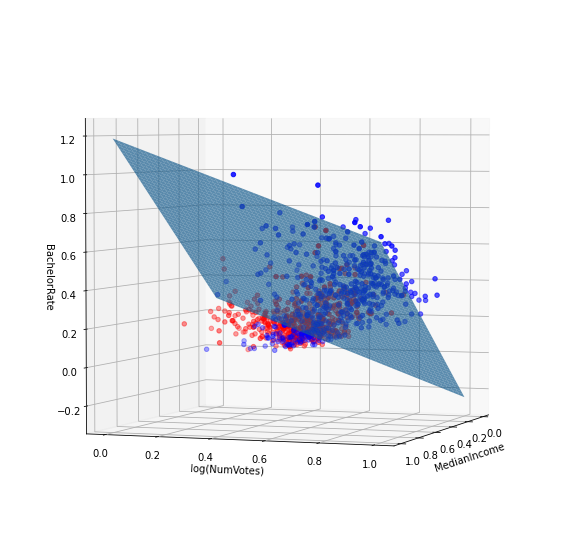

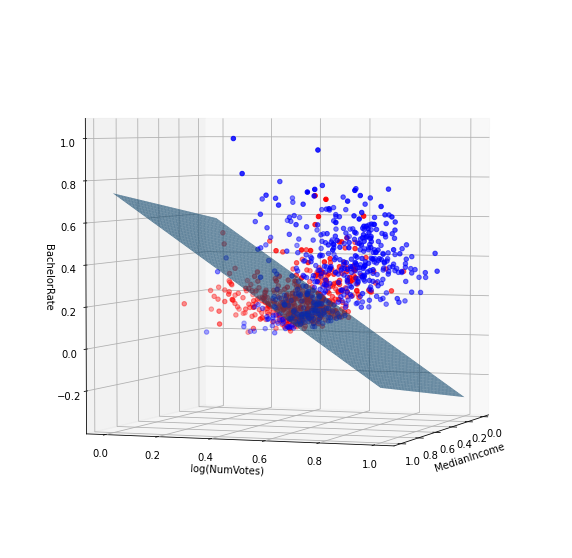

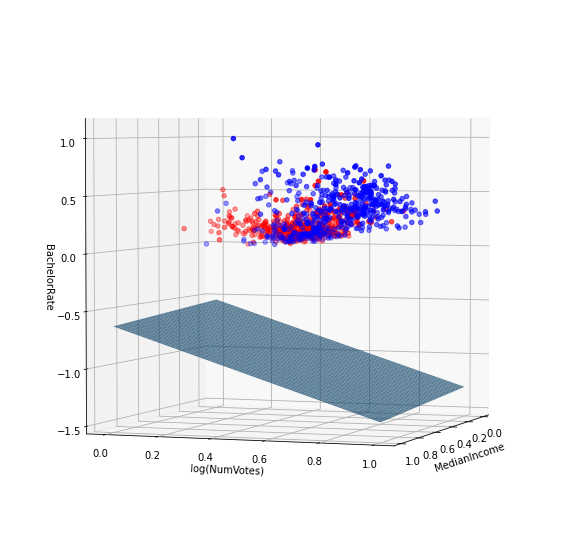

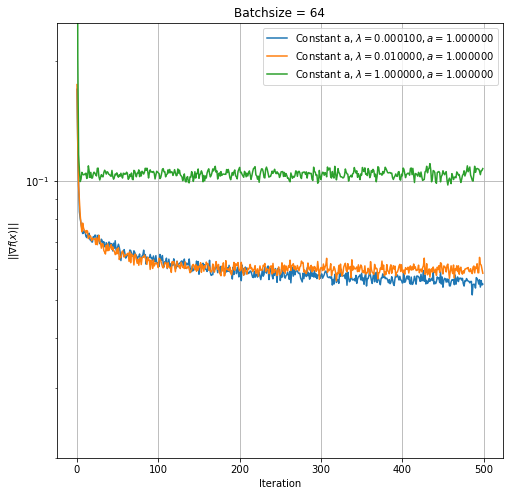

In [80]:
lams = np.array([1e-4,1e-2,1,100])
a_vals = np.array([1])
batchsizes = np.array([64])
j = 0
k = 0
trialiter = 0
plotitr = 500
for i in range(len(lams)-1):
    xiter = np.loadtxt('Data/SG_xfin_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]),delimiter = ',')
    wplot = xiter[trialiter,:4]

    fig2 = plt.figure(figsize = (10,10))
    ax = fig2.add_subplot(111, projection='3d')
    ax.scatter(XX[idem,0],XX[idem,1],XX[idem,2],c = 'b')
    ax.scatter(XX[irep,0],XX[irep,1],XX[irep,2],c = 'r')
    nn = 50
    xx,yy = np.meshgrid(np.linspace(0,1,num=nn),np.linspace(0,1,num=nn))
    zplot = (-wplot[0]*xx -wplot[1]*yy-wplot[3])/wplot[2]
    ax.plot_surface(xx,yy,zplot,alpha = 0.7)
    ax.view_init(3,20)
    ax.set_xlabel(X.columns[i1])
    ax.set_ylabel(X.columns[i2])
    ax.set_zlabel(X.columns[i3])
    plt.savefig('SGD_dividingplane_lam%f_trial%d.png' % (lams[i],trialiter),transparent = True,bbox_inches = 'tight')
    plt.show()

fig2 = plt.figure(figsize = (8,8))
for i in range(len(lams)-1):
    gradnorm = np.loadtxt('Data/SG_gradnorm_consta%f_lam%f_batchsize%d.csv' % (a_vals[j],lams[i],batchsizes[k]),delimiter = ',')
    plt.plot(np.arange(plotitr),gradnorm[:plotitr],label = r'Constant a, $\lambda = %f, a = %f$' % (lams[i],1))
    
plt.legend()
plt.xlabel('Iteration')
plt.ylabel(r'$||\nabla f(x)||$')
plt.yscale('log')
plt.ylim([2e-2,0.25])
plt.title('Batchsize = %d' % batchsizes[k])
plt.grid(True)
plt.savefig('SGD_compare_gradnorm_lambda_batchsize64.png' % batchsizes[k], transparent = True,bbox_inches = 'tight')
plt.show()


In [61]:
plot_itr = 500
i = 0
ajc = 2
aje = 3
lams = np.array([1e-2])
m0 = 10
batchsizes = np.array([16,32,64,128,256])
for k in range(len(batchsizes)):
    plt.figure(figsize = (8,8))
    plt.plot(np.arange(plot_itr),avg_fmat[:plot_itr,i,ajc,k],label = r'Constant a, $\lambda = %f, a = %f$' % (lams[i],a_vals[ajc]))
    plt.plot(np.arange(plot_itr),avg_fmathalf[:plot_itr,i,aje,k],label = r'Exponential decay, $\lambda = %f, a_0 = %f,m_0=%d$' % (lams[i],a_vals[aje],m0))
    plt.plot(np.arange(plot_itr),avg_fmatitr[:plot_itr,i,k],label = r'a = 1/k, $\lambda = %f$' % (lams[i]))
    plt.plot(np.arange(plot_itr),avg_fmatlinesearch[:plot_itr,i,k],':',label = r'Linesearch, $\lambda = %f$' % (lams[i]))
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('f(x)')
    plt.ylim([0.6,0.75])
    plt.title('Batchsize = %d' % batchsizes[k])
    plt.grid(True)
    plt.savefig('SGD_compare_f_batchsize%d.png' % batchsizes[k], transparent = True,bbox_inches = 'tight')
    plt.show()

for k in range(len(batchsizes)):
    plt.figure(figsize = (8,8))
    plt.plot(np.arange(plot_itr),avg_gradnormmat[:plot_itr,i,ajc,k],label = r'Constant a, $\lambda = %f, a = %f$' % (lams[i],a_vals[ajc]))
    plt.plot(np.arange(plot_itr),avg_gradnormmathalf[:plot_itr,i,aje,k],label = r'Exponential decay, $\lambda = %f, a_0 = %f,m_0=%d$' % (lams[i],a_vals[aje],m0))
    plt.plot(np.arange(plot_itr),avg_gradnormmatitr[:plot_itr,i,k],label = r'a = 1/k, $\lambda = %f$' % (lams[i]))
    plt.plot(np.arange(plot_itr),avg_gradnormmatlinesearch[:plot_itr,i,k],':',label = r'Linesearch, $\lambda = %f$' % (lams[i]))
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel(r'$||\nabla f(x)||$')
    plt.yscale('log')
    plt.ylim([2e-2,0.25])
    plt.title('Batchsize = %d' % batchsizes[k])
    plt.grid(True)
    plt.savefig('SGD_compare_gradnorm_batchsize%d.png' % batchsizes[k], transparent = True,bbox_inches = 'tight')
    plt.show()

for k in range(len(batchsizes)):
    plt.figure(figsize = (8,8))
    plt.plot(np.arange(plot_itr),avg_runtime[:plot_itr,i,ajc,k],label = r'Constant a, $\lambda = %f, a = %f$' % (lams[i],a_vals[ajc]))
    plt.plot(np.arange(plot_itr),avg_runtimehalf[:plot_itr,i,aje,k],label = r'Exponential decay, $\lambda = %f, a_0 = %f,m_0=%d$' % (lams[i],a_vals[aje],m0))
    plt.plot(np.arange(plot_itr),avg_runtimeitr[:plot_itr,i,k],label = r'a = 1/k, $\lambda = %f$' % (lams[i]))
    plt.plot(np.arange(plot_itr),avg_runtimelinesearch[:plot_itr,i,k],':',label = r'Linesearch, $\lambda = %f$' % (lams[i]))
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Run Time (s)')
    plt.ylim([0,0.15])
    plt.title('Batchsize = %d' % batchsizes[k])
    plt.grid(True)
    plt.savefig('SGD_compare_runtime_batchsize%d.png' % batchsizes[k], transparent = True,bbox_inches = 'tight')
    plt.show()

IndexError: index 2 is out of bounds for axis 2 with size 1

<Figure size 576x576 with 0 Axes>

Varying the value of $\lambda$ while keeping all other parameters fixed, I find that...

In [ ]:
# Results for varying lambda

## Questions 3 & 4
### I experiment with different batch sizes using inexact Newton's method and stochastic L-BFGS and compare the accuracy and runtimes to those from the best results from SGD.

In [15]:
maxiter = 500
trials = 1000
lam = 0.01
batchsizes = np.array([16,32,64,128,256])
w = np.array([1,1,-1,-1])
from tqdm import tqdm
getdataSIN = False
getdataSLB = False

fun = lambda I,Y,w: fun0(I,Y,w,lam)
gfun = lambda I,Y,w: gfun0(I,Y,w,lam)
Hvec = lambda I,Y,w,v: Hvec0(I,Y,w,v,lam)

if getdataSIN:
    total_iters = len(batchsizes)*trials
    
    fmatSIN = np.zeros((trials,maxiter+1,len(batchsizes)))
    gradnormmatSIN = np.zeros((trials,maxiter,len(batchsizes)))
    xfinSIN = np.zeros((trials,w.size,len(batchsizes)))
    runtimeSIN = np.zeros((trials,maxiter,len(batchsizes)))
    
    with tqdm(total = total_iters) as pbar:
        for k in range(len(batchsizes)):
            for l in range(trials):
                xfinSIN[l,:,k], fmatSIN[l,:,k], gradnormmatSIN[l,:,k], runtimeSIN[l, : ,k] \
                    = SINewton(fun, gfun, Hvec, Y, w, batchsize = batchsizes[k], kmax = maxiter) 
                pbar.update(1)
            np.savetxt('Data/SINewton_fvals_lam%f_batchsize%d.csv' % (lam,batchsizes[k]), np.mean(fmatSIN[:,:,k],axis = 0),delimiter = ',')
            np.savetxt('Data/SINewton_gradnorm_lam%f_batchsize%d.csv' % (lam,batchsizes[k]), np.mean(gradnormmatSIN[:,:,k],axis = 0),delimiter = ',')
            np.savetxt('Data/SINewton_xfin_lam%f_batchsize%d.csv' % (lam,batchsizes[k]), xfinSIN[:,:,k],delimiter = ',')
            np.savetxt('Data/SINewton_runtime_lam%f_batchsize%d.csv' % (lam,batchsizes[k]), np.mean(runtimeSIN[:,:,k],axis = 0),delimiter = ',')
if getdataSLB:
    batchsizesg = np.array([16,32,64,128])
    batchsizesH = np.array([64,256])
    a_vals = np.array([1e-1,1,10])
    Mvals = np.array([5,10,20])
    
    total_iters = len(Mvals)*len(batchsizesH)*len(a_vals)*len(batchsizesg)*trials*2 + len(batchsizesH)*len(batchsizes)*len(Mvals)*trials*2
    
    fmatSLB = np.zeros((trials,maxiter+1,len(batchsizesg),len(batchsizesH),len(Mvals)))
    gradnormmatSLB = np.zeros((trials,maxiter+1,len(batchsizesg),len(batchsizesH),len(Mvals)))
    xfinSLB = np.zeros((trials,w.size,len(batchsizesg),len(batchsizesH),len(Mvals)))
    runtimeSLB = np.zeros((trials,maxiter+1,len(batchsizesg),len(batchsizesH),len(Mvals)))
    
    fmatconstSLB = np.zeros((trials,maxiter+1,len(a_vals),len(batchsizesg),len(batchsizesH),len(Mvals)))
    gradnormmatconstSLB = np.zeros((trials,maxiter+1,len(a_vals),len(batchsizesg),len(batchsizesH),len(Mvals)))
    xfinconstSLB = np.zeros((trials,w.size,len(a_vals),len(batchsizesg),len(batchsizesH),len(Mvals)))
    runtimeconstSLB = np.zeros((trials,maxiter+1,len(a_vals),len(batchsizesg),len(batchsizesH),len(Mvals)))

    fmathalfSLB = np.zeros((trials,maxiter+1,len(a_vals),len(batchsizesg),len(batchsizesH),len(Mvals)))
    gradnormmathalfSLB = np.zeros((trials,maxiter+1,len(a_vals),len(batchsizesg),len(batchsizesH),len(Mvals)))
    xfinhalfSLB = np.zeros((trials,w.size,len(a_vals),len(batchsizesg),len(batchsizesH),len(Mvals)))
    runtimehalfSLB = np.zeros((trials,maxiter+1,len(a_vals),len(batchsizesg),len(batchsizesH),len(Mvals)))

    fmatitrSLB = np.zeros((trials,maxiter+1,len(batchsizesg),len(batchsizesH),len(Mvals)))
    gradnormmatitrSLB = np.zeros((trials,maxiter+1,len(batchsizesg),len(batchsizesH),len(Mvals)))
    xfinitrSLB = np.zeros((trials,w.size,len(batchsizesg),len(batchsizesH),len(Mvals)))
    runtimeitrSLB = np.zeros((trials,maxiter+1,len(batchsizesg),len(batchsizesH),len(Mvals)))
    with tqdm(total = total_iters) as pbar:
        for i in range(len(Mvals)):
            for j in range(len(a_vals)):
                aconst = lambda itr: aconst0(itr,a_vals[j])
                ahalf = lambda itr: ahalf0(itr, m0, a_vals[j])
                if j == 0:
                    for k in range(len(batchsizesg)):
                        for m in range(len(batchsizesH)):
                            for l in range(trials):
                                xiter, fmatSLB[l,:,k,m,i], gradnormmatSLB[l,:,k,m,i], runtimeSLB[l, : ,k,m,i] \
                                    = SLBFGS(fun, gfun, Y, w,batchsizeg = batchsizesg[k], batchsizeH = batchsizesH[m],\
                                         stepsperHupdate = Mvals[i], maxiter = maxiter)
                                xfinSLB[l,:,k,m,i] = xiter[-1,:w.size]
                                pbar.update(1)
                                xiter, fmatitrSLB[l,:,k,m,i], gradnormmatitrSLB[l,:,k,m,i], runtimeitrSLB[l, : ,k,m,i] \
                                    = SLBFGS(fun, gfun, Y, w,batchsizeg = batchsizesg[k], batchsizeH = batchsizesH[m],\
                                         stepsperHupdate = Mvals[i], maxiter = maxiter, stepmethod = aitr)
                                xfinitrSLB[l,:,k,m,i] = xiter[-1,:w.size]
                                pbar.update(1)
                                xiter, fmatconstSLB[l,:,j,k,m,i], gradnormmatconstSLB[l,:,j,k,m,i], runtimeconstSLB[l, : ,j,k,m,i] \
                                    = SLBFGS(fun, gfun, Y, w,batchsizeg = batchsizesg[k], batchsizeH = batchsizesH[m],\
                                         stepsperHupdate = Mvals[i], maxiter = maxiter, stepmethod = aconst)
                                xfinconstSLB[l,:,j,k,m,i] = xiter[-1,:w.size]
                                pbar.update(1)
                                xiter, fmathalfSLB[l,:,j,k,m,i], gradnormmathalfSLB[l,:,j,k,m,i], runtimehalfSLB[l, : ,j,k,m,i] \
                                    = SLBFGS(fun, gfun, Y, w,batchsizeg = batchsizesg[k], batchsizeH = batchsizesH[m],\
                                         stepsperHupdate = Mvals[i], maxiter = maxiter, stepmethod = ahalf)
                                xfinhalfSLB[l,:,j,k,m,i] = xiter[-1,:w.size]
                                pbar.update(1)
                            np.savetxt('Data/SLBFGS_fvals_consta%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(fmatconstSLB[:,:,j,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_fvals_halfa%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(fmathalfSLB[:,:,j,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_fvals_linesearch_batchsizeg%d_batchsizeH%d_M%d.csv' % (batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(fmatSLB[:,:,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_fvals_k-1_batchsizeg%d_batchsizeH%d_M%d.csv' % (batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(fmatitrSLB[:,:,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_gradnorm_consta%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(gradnormmatconstSLB[:,:,j,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_gradnorm_halfa%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(gradnormmathalfSLB[:,:,j,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_gradnorm_linesearch_batchsizeg%d_batchsizeH%d_M%d.csv' % (batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(gradnormmatSLB[:,:,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_gradnorm_k-1_batchsizeg%d_batchsizeH%d_M%d.csv' % (batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(gradnormmatitrSLB[:,:,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_xfin_consta%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), xfinconstSLB[:,:,j,k,m,i],delimiter = ',')
                            np.savetxt('Data/SLBFGS_xfin_halfa%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), xfinhalfSLB[:,:,j,k,m,i],delimiter = ',')
                            np.savetxt('Data/SLBFGS_xfin_linesearch_batchsizeg%d_batchsizeH%d_M%d.csv' % (batchsizesg[k],batchsizesH[m],Mvals[i]), xfinSLB[:,:,k,m,i],delimiter = ',')
                            np.savetxt('Data/SLBFGS_xfin_k-1_batchsizeg%d_batchsizeH%d_M%d.csv' % (batchsizesg[k],batchsizesH[m],Mvals[i]), xfinitrSLB[:,:,k,m,i],delimiter = ',')
                            np.savetxt('Data/SLBFGS_runtime_consta%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(runtimeconstSLB[:,:,j,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_runtime_halfa%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(runtimehalfSLB[:,:,j,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_runtime_linesearch_batchsizeg%d_batchsizeH%d_M%d.csv' % (batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(runtimeSLB[:,:,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_runtime_k-1_batchsizeg%d_batchsizeH%d_M%d.csv' % (batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(runtimeitrSLB[:,:,k,m,i],axis = 0),delimiter = ',')
                        
                    #print(i,j,k)
                else:
                    for k in range(len(batchsizesg)):
                        for m in range(len(batchsizesH)):
                            for l in range(trials):
                                xiter, fmatconstSLB[l,:,j,k,m,i], gradnormmatconstSLB[l,:,j,k,m,i], runtimeconstSLB[l, : ,j,k,m,i] \
                                    = SLBFGS(fun, gfun, Y, w,batchsizeg = batchsizesg[k], batchsizeH = batchsizesH[m],\
                                         stepsperHupdate = Mvals[i], maxiter = maxiter, stepmethod = aconst)
                                xfinconstSLB[l,:,j,k,m,i] = xiter[-1,:w.size]
                                pbar.update(1)
                                xiter, fmathalfSLB[l,:,j,k,m,i], gradnormmathalfSLB[l,:,j,k,m,i], runtimehalfSLB[l, : ,j,k,m,i] \
                                    = SLBFGS(fun, gfun, Y, w,batchsizeg = batchsizesg[k], batchsizeH = batchsizesH[m],\
                                         stepsperHupdate = Mvals[i], maxiter = maxiter, stepmethod = ahalf)
                                xfinhalfSLB[l,:,j,k,m,i] = xiter[-1,:w.size]
                                pbar.update(1)
                            np.savetxt('Data/SLBFGS_fvals_consta%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(fmatconstSLB[:,:,j,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_fvals_halfa%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(fmathalfSLB[:,:,j,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_gradnorm_consta%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(gradnormmatconstSLB[:,:,j,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_gradnorm_halfa%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(gradnormmathalfSLB[:,:,j,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_xfin_consta%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), xfinconstSLB[:,:,j,k,m,i],delimiter = ',')
                            np.savetxt('Data/SLBFGS_xfin_halfa%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), xfinhalfSLB[:,:,j,k,m,i],delimiter = ',')
                            np.savetxt('Data/SLBFGS_runtime_consta%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(runtimeconstSLB[:,:,j,k,m,i],axis = 0),delimiter = ',')
                            np.savetxt('Data/SLBFGS_runtime_halfa%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]), np.mean(runtimehalfSLB[:,:,j,k,m,i],axis = 0),delimiter = ',')
                    #print(i,j,k)

In [24]:
maxiter = 1000
trials = 1000
lam = 0.01
batchsizes = np.array([16,32,64,128,256])

avg_fmatSIN = np.zeros((maxiter+1,len(batchsizes)))
avg_gradnormmatSIN = np.zeros((maxiter,len(batchsizes)))
avg_runtimeSIN = np.zeros((maxiter,len(batchsizes)))
for k in range(len(batchsizes)-1,len(batchsizes)):
    avg_fmatSIN[:,k] = np.loadtxt('Data/SINewton_fvals_lam%f_batchsize%d.csv' % (lam,batchsizes[k]),delimiter = ',')
    avg_gradnormmatSIN[:,k] = np.loadtxt('Data/SINewton_gradnorm_lam%f_batchsize%d.csv' % (lam,batchsizes[k]), delimiter = ',')
    avg_runtimeSIN[:,k] = np.loadtxt('Data/SINewton_runtime_lam%f_batchsize%d.csv' % (lam,batchsizes[k]),delimiter = ',')

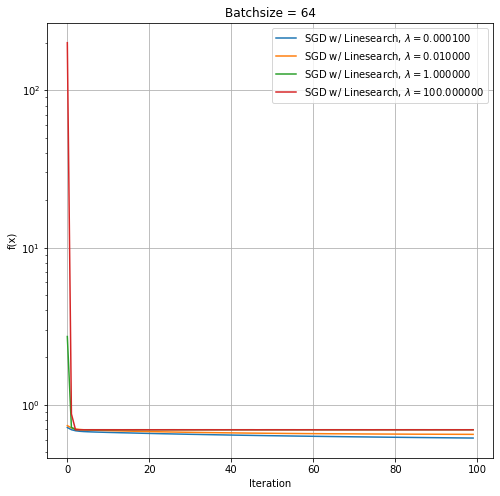

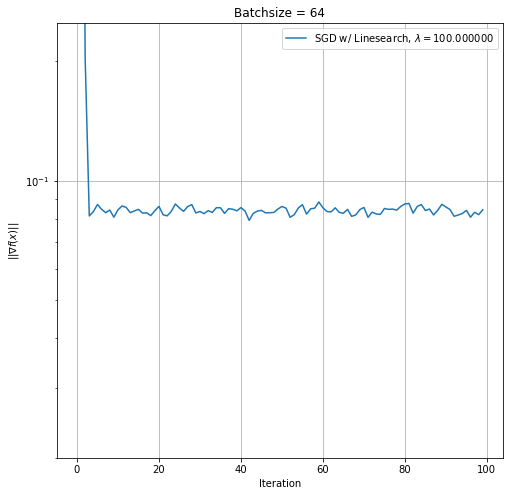

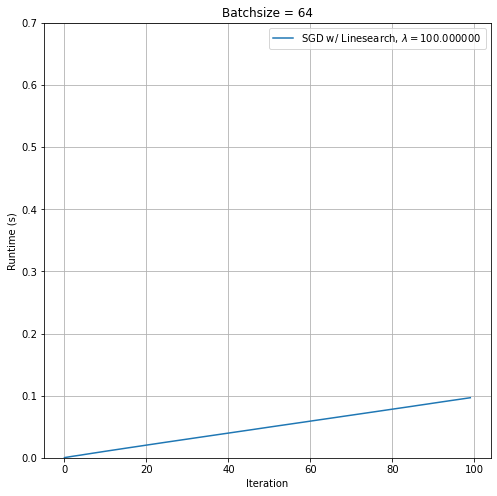

In [65]:
plot_itr = 100
i = 0
j = 2
lams = np.array([1e-4,1e-2,1,100])
m0 = 100
batchsizes = np.array([64])
k = 0
plt.figure(figsize = (8,8))
for i in range(len(lams)):
    plt.plot(np.arange(plot_itr),avg_fmatlinesearch[:plot_itr,i,k],label = r'SGD w/ Linesearch, $\lambda = %f$' % (lams[i]))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('f(x)')
plt.yscale('log')
# plt.ylim([0.64,0.75])
plt.title('Batchsize = %d' % batchsizes[k])
plt.grid(True)
# plt.savefig('SGD_vs_SINewton_compare_f_batchsize%d.png' % batchsizes[k], transparent = True,bbox_inches = 'tight')
plt.show()



for k in range(len(batchsizes)-1,len(batchsizes)):
    plt.figure(figsize = (8,8))
    plt.plot(np.arange(plot_itr),avg_gradnormmatlinesearch[:plot_itr,i,k],label = r'SGD w/ Linesearch, $\lambda = %f$' % (lams[i]))
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel(r'$||\nabla f(x)||$')
    plt.yscale('log')
    plt.ylim([2e-2,0.25])
    plt.title('Batchsize = %d' % batchsizes[k])
    plt.grid(True)
    # plt.savefig('SGD_vs_SINewton_compare_gradnorm_batchsize%d.png' % batchsizes[k], transparent = True,bbox_inches = 'tight')
    plt.show()
    
for k in range(len(batchsizes)-1,len(batchsizes)):
    plt.figure(figsize = (8,8))
    plt.plot(np.arange(plot_itr),avg_runtimelinesearch[:plot_itr,i,k],label = r'SGD w/ Linesearch, $\lambda = %f$' % (lams[i]))
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Runtime (s)')
    plt.title('Batchsize = %d' % batchsizes[k])
    plt.ylim(0,0.7)
    plt.grid(True)
    # plt.savefig('SGD_vs_SINewton_compare_runtime_batchsize%d.png' % batchsizes[k], transparent = True,bbox_inches = 'tight')
    plt.show()

In [95]:
maxiter = 500
trials = 1000
lam = 0.01
batchsizesg = np.array([16,32,64,128])
batchsizesH = np.array([64,256])
a_vals = np.array([1e-1,1,10])
Mvals = np.array([5,10,20])
total_iters = len(lams)*len(a_vals)*len(batchsizes)*2 + len(lams)*len(batchsizes)

avg_fmatSLB = np.zeros((maxiter+1,len(batchsizesg),len(batchsizesH),len(Mvals)))
avg_gradnormmatSLB = np.zeros((maxiter+1,len(batchsizesg),len(batchsizesH),len(Mvals)))
avg_runtimeSLB = np.zeros((maxiter+1,len(batchsizesg),len(batchsizesH),len(Mvals)))

avg_fmathalfSLB = np.zeros((maxiter+1,len(a_vals),len(batchsizesg),len(batchsizesH),len(Mvals)))
avg_gradnormmathalfSLB = np.zeros((maxiter+1,len(a_vals),len(batchsizesg),len(batchsizesH),len(Mvals)))
avg_runtimehalfSLB = np.zeros((maxiter+1,len(a_vals),len(batchsizesg),len(batchsizesH),len(Mvals)))

avg_fmatitrSLB = np.zeros((maxiter+1,len(batchsizesg),len(batchsizesH),len(Mvals)))
avg_gradnormmatitrSLB = np.zeros((maxiter+1,len(batchsizesg),len(batchsizesH),len(Mvals)))
avg_runtimeitrSLB = np.zeros((maxiter+1,len(batchsizesg),len(batchsizesH),len(Mvals)))

avg_fmatconstSLB = np.zeros((maxiter+1,len(a_vals),len(batchsizesg),len(batchsizesH),len(Mvals)))
avg_gradnormmatconstSLB = np.zeros((maxiter+1,len(a_vals),len(batchsizesg),len(batchsizesH),len(Mvals)))
avg_runtimeconstSLB = np.zeros((maxiter+1,len(a_vals),len(batchsizesg),len(batchsizesH),len(Mvals)))
for i in range(len(Mvals)):
    for j in range(len(a_vals)):
        aconst = lambda itr: aconst0(itr,a_vals[j])
        ahalf = lambda itr: ahalf0(itr, m0, a_vals[j])
        if j == 0:
            for k in range(len(batchsizesg)):
                for m in range(len(batchsizesH)):
                    avg_fmatconstSLB[:,j,k,m,i] = np.loadtxt('Data/SLBFGS_fvals_consta%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_fmathalfSLB[:,j,k,m,i] = np.loadtxt('Data/SLBFGS_fvals_halfa%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_fmatSLB[:,k,m,i] = np.loadtxt('Data/SLBFGS_fvals_linesearch_batchsizeg%d_batchsizeH%d_M%d.csv' % (batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_fmatitrSLB[:,k,m,i] = np.loadtxt('Data/SLBFGS_fvals_k-1_batchsizeg%d_batchsizeH%d_M%d.csv' % (batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_gradnormmatconstSLB[:,j,k,m,i] = np.loadtxt('Data/SLBFGS_gradnorm_consta%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_gradnormmathalfSLB[:,j,k,m,i] = np.loadtxt('Data/SLBFGS_gradnorm_halfa%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_gradnormmatSLB[:,k,m,i] = np.loadtxt('Data/SLBFGS_gradnorm_linesearch_batchsizeg%d_batchsizeH%d_M%d.csv' % (batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_gradnormmatitrSLB[:,k,m,i] = np.loadtxt('Data/SLBFGS_gradnorm_k-1_batchsizeg%d_batchsizeH%d_M%d.csv' % (batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_runtimeconstSLB[:,j,k,m,i] = np.loadtxt('Data/SLBFGS_runtime_consta%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_runtimehalfSLB[:,j,k,m,i] = np.loadtxt('Data/SLBFGS_runtime_halfa%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_runtimeSLB[:,k,m,i] = np.loadtxt('Data/SLBFGS_runtime_linesearch_batchsizeg%d_batchsizeH%d_M%d.csv' % (batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_runtimeitrSLB[:,k,m,i] = np.loadtxt('Data/SLBFGS_runtime_k-1_batchsizeg%d_batchsizeH%d_M%d.csv' % (batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')

            #print(i,j,k)
        else:
            for k in range(len(batchsizesg)):
                for m in range(len(batchsizesH)):
                    avg_fmatconstSLB[:,j,k,m,i] = np.loadtxt('Data/SLBFGS_fvals_consta%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_fmathalfSLB[:,j,k,m,i] = np.loadtxt('Data/SLBFGS_fvals_halfa%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_gradnormmatconstSLB[:,j,k,m,i] = np.loadtxt('Data/SLBFGS_gradnorm_consta%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_gradnormmathalfSLB[:,j,k,m,i] = np.loadtxt('Data/SLBFGS_gradnorm_halfa%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_runtimeconstSLB[:,j,k,m,i] = np.loadtxt('Data/SLBFGS_runtime_consta%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')
                    avg_runtimehalfSLB[:,j,k,m,i] = np.loadtxt('Data/SLBFGS_runtime_halfa%f_batchsizeg%d_batchsizeH%d_M%d.csv' % (a_vals[j],batchsizesg[k],batchsizesH[m],Mvals[i]),delimiter = ',')

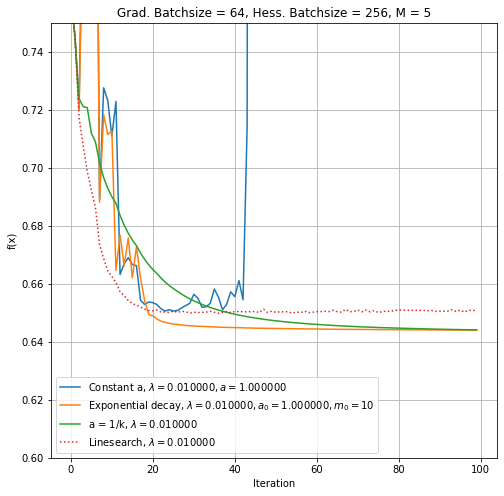

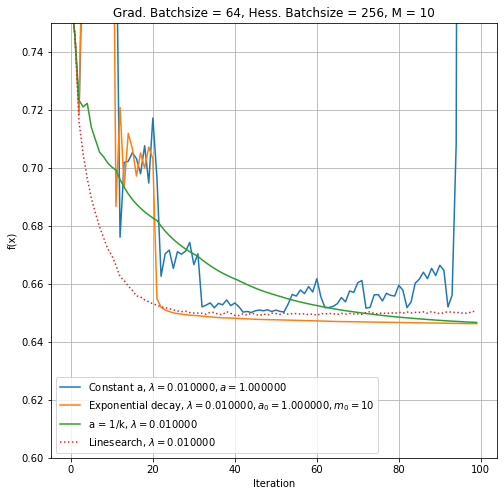

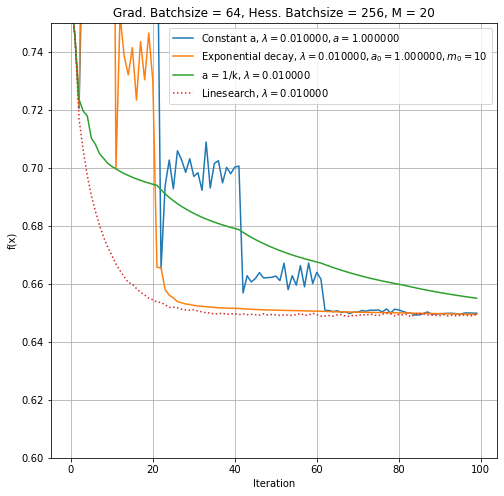

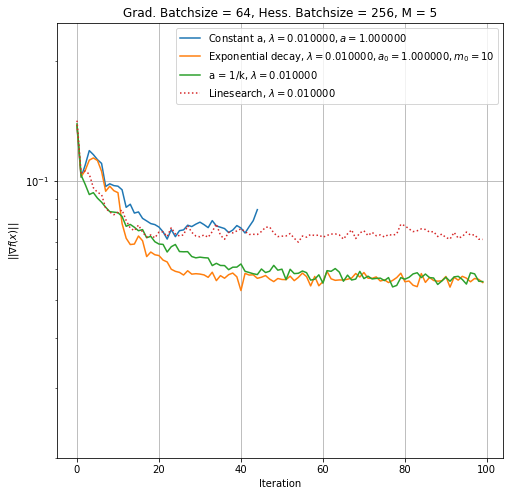

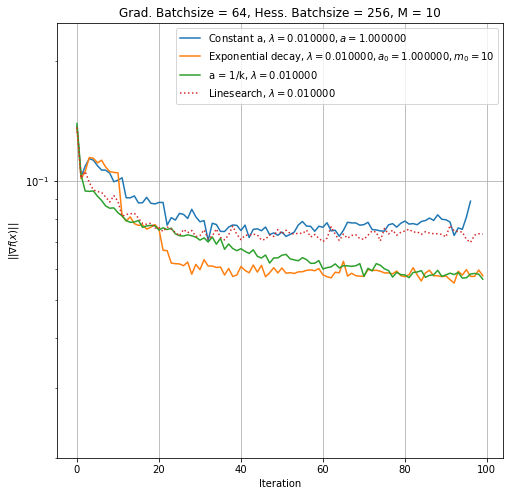

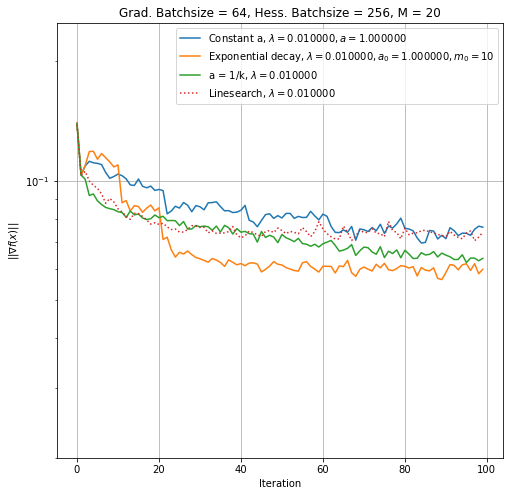

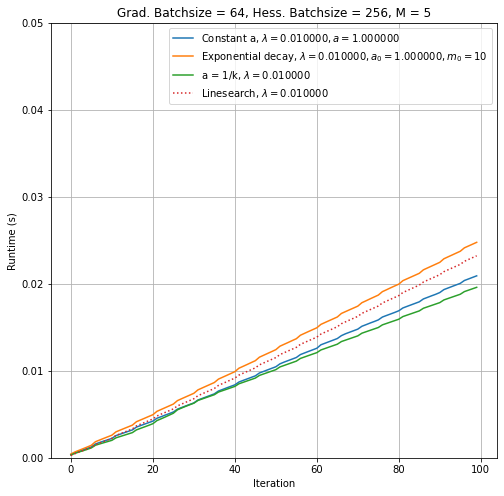

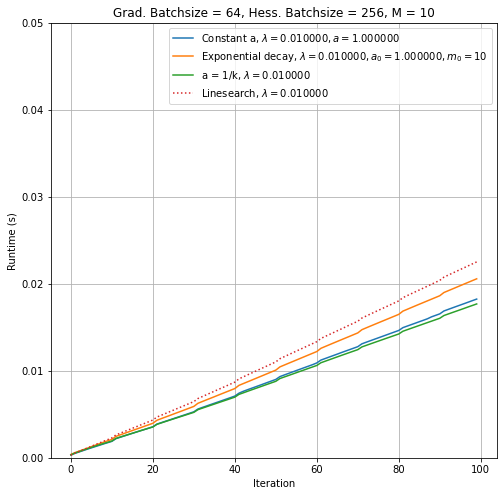

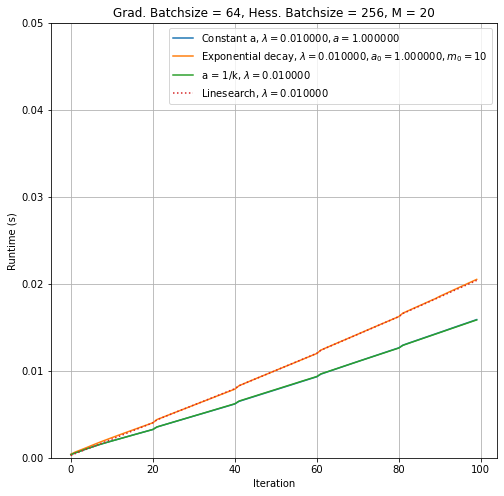

In [97]:
plot_itr = 100
i = 0
ajc = 1
aje = 1
lams = np.array([1e-2])
m0 = 10
maxiter = 500
trials = 1000
lam = 0.01
batchsizesg = np.array([16,32,64,128])
batchsizesH = np.array([64,256])
a_vals = np.array([1e-1,1,10])
Mvals = np.array([5,10,20])
batchsizesgidx = 2
batchsizesHidx = 1
for k in range(len(Mvals)):
    plt.figure(figsize = (8,8))
    plt.plot(np.arange(plot_itr),avg_fmatconstSLB[:plot_itr,ajc,batchsizesgidx,batchsizesHidx,k],label = r'Constant a, $\lambda = %f, a = %f$' % (lams[i],a_vals[ajc]))
    plt.plot(np.arange(plot_itr),avg_fmathalfSLB[:plot_itr,aje,batchsizesgidx,batchsizesHidx,k],label = r'Exponential decay, $\lambda = %f, a_0 = %f,m_0=%d$' % (lams[i],a_vals[aje],m0))
    plt.plot(np.arange(plot_itr),avg_fmatitrSLB[:plot_itr,batchsizesgidx,batchsizesHidx,k],label = r'a = 1/k, $\lambda = %f$' % (lams[i]))
    plt.plot(np.arange(plot_itr),avg_fmatSLB[:plot_itr,batchsizesgidx,batchsizesHidx,k],':',label = r'Linesearch, $\lambda = %f$' % (lams[i]))
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('f(x)')
    plt.ylim([0.6,0.75])
    plt.title('Grad. Batchsize = %d, Hess. Batchsize = %d, M = %d' % (batchsizesg[batchsizesgidx],batchsizesH[batchsizesHidx],Mvals[k]))
    plt.grid(True)
    plt.savefig('SLBFGS_compare_f_batchsizeg%d_batchsizeH%d_M%d.png' % (batchsizesg[batchsizesgidx],batchsizesH[batchsizesHidx],Mvals[k]), transparent = True,bbox_inches = 'tight')
    plt.show()

for k in range(len(Mvals)):
    plt.figure(figsize = (8,8))
    plt.plot(np.arange(plot_itr),avg_gradnormmatconstSLB[:plot_itr,ajc,batchsizesgidx,batchsizesHidx,k],label = r'Constant a, $\lambda = %f, a = %f$' % (lams[i],a_vals[ajc]))
    plt.plot(np.arange(plot_itr),avg_gradnormmathalfSLB[:plot_itr,aje,batchsizesgidx,batchsizesHidx,k],label = r'Exponential decay, $\lambda = %f, a_0 = %f,m_0=%d$' % (lams[i],a_vals[aje],m0))
    plt.plot(np.arange(plot_itr),avg_gradnormmatitrSLB[:plot_itr,batchsizesgidx,batchsizesHidx,k],label = r'a = 1/k, $\lambda = %f$' % (lams[i]))
    plt.plot(np.arange(plot_itr),avg_gradnormmatSLB[:plot_itr,batchsizesgidx,batchsizesHidx,k],':',label = r'Linesearch, $\lambda = %f$' % (lams[i]))
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel(r'$||\nabla f(x)||$')
    plt.yscale('log')
    plt.ylim([2e-2,0.25])
    plt.title('Grad. Batchsize = %d, Hess. Batchsize = %d, M = %d' % (batchsizesg[batchsizesgidx],batchsizesH[batchsizesHidx],Mvals[k]))
    plt.grid(True)
    plt.savefig('SLBFGS_compare_gradnorm_batchsizeg%d_batchsizeH%d_M%d.png' % (batchsizesg[batchsizesgidx],batchsizesH[batchsizesHidx],Mvals[k]), transparent = True,bbox_inches = 'tight')
    plt.show()

for k in range(len(Mvals)):
    plt.figure(figsize = (8,8))
    plt.plot(np.arange(plot_itr),avg_runtimeconstSLB[:plot_itr,ajc,batchsizesgidx,batchsizesHidx,k],label = r'Constant a, $\lambda = %f, a = %f$' % (lams[i],a_vals[ajc]))
    plt.plot(np.arange(plot_itr),avg_runtimehalfSLB[:plot_itr,aje,batchsizesgidx,batchsizesHidx,k],label = r'Exponential decay, $\lambda = %f, a_0 = %f,m_0=%d$' % (lams[i],a_vals[aje],m0))
    plt.plot(np.arange(plot_itr),avg_runtimeitrSLB[:plot_itr,batchsizesgidx,batchsizesHidx,k],label = r'a = 1/k, $\lambda = %f$' % (lams[i]))
    plt.plot(np.arange(plot_itr),avg_runtimeSLB[:plot_itr,batchsizesgidx,batchsizesHidx,k],':',label = r'Linesearch, $\lambda = %f$' % (lams[i]))
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Runtime (s)')
    plt.title('Grad. Batchsize = %d, Hess. Batchsize = %d, M = %d' % (batchsizesg[batchsizesgidx],batchsizesH[batchsizesHidx],Mvals[k]))
    plt.ylim(0,0.05)
    plt.grid(True)
    plt.savefig('SLBFGS_compare_runtime_batchsizeg%d_batchsizeH%d_M%d.png' % (batchsizesg[batchsizesgidx],batchsizesH[batchsizesHidx],Mvals[k]), transparent = True,bbox_inches = 'tight')
    plt.show()

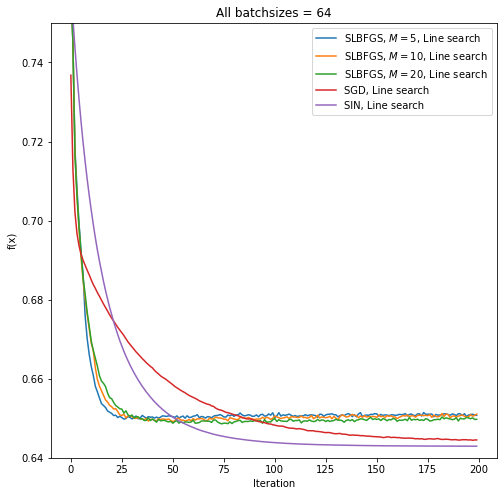

In [113]:
fvalSLBm5 = np.loadtxt('Data/SLBFGS_fvals_linesearch_batchsizeg%d_batchsizeH%d_M%d.csv' % \
                       (64,64,5),delimiter = ',')
fvalSLBm10 = np.loadtxt('Data/SLBFGS_fvals_linesearch_batchsizeg%d_batchsizeH%d_M%d.csv' % \
                       (64,64,10),delimiter = ',')
fvalSLBm20 = np.loadtxt('Data/SLBFGS_fvals_linesearch_batchsizeg%d_batchsizeH%d_M%d.csv' % \
                       (64,64,20),delimiter = ',')
fvalSIN =  np.loadtxt('Data/SINewton_fvals_lam%f_batchsize%d.csv' % (0.01,64),delimiter = ',')

fvalSGD = np.loadtxt('Data/SG_fvals_linesearch_lam%f_batchsize%d.csv' % (0.01,64), delimiter = ',')

plot_itr = 200
plt.figure(figsize = (8,8))
plt.plot(np.arange(plot_itr),fvalSLBm5[:plot_itr],label = r'SLBFGS, $M=5$, Line search')
plt.plot(np.arange(plot_itr),fvalSLBm10[:plot_itr],label = r'SLBFGS, $M=10$, Line search')
plt.plot(np.arange(plot_itr),fvalSLBm20[:plot_itr],label = r'SLBFGS, $M=20$, Line search')
plt.plot(np.arange(plot_itr),fvalSGD[:plot_itr],label = r'SGD, Line search')
plt.plot(np.arange(plot_itr),fvalSIN[:plot_itr],label = r'SIN, Line search')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('f(x)')
plt.ylim([0.64,0.75])
plt.title('All batchsizes = %d' % (64))
plt.savefig('Compare_methods_f_batchsize64.png')
plt.show()

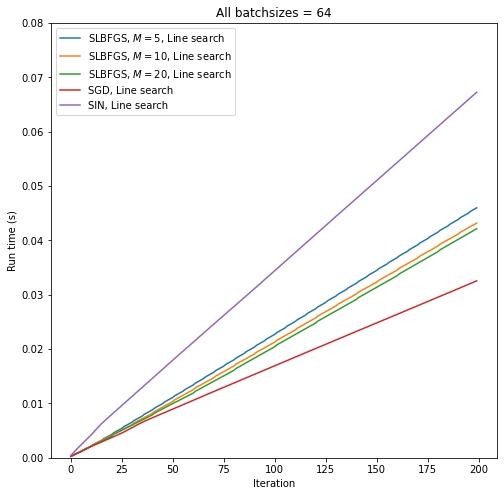

In [115]:
runtimeSLBm5 = np.loadtxt('Data/SLBFGS_runtime_linesearch_batchsizeg%d_batchsizeH%d_M%d.csv' % \
                       (64,64,5),delimiter = ',')
runtimeSLBm10 = np.loadtxt('Data/SLBFGS_runtime_linesearch_batchsizeg%d_batchsizeH%d_M%d.csv' % \
                       (64,64,10),delimiter = ',')
runtimeSLBm20 = np.loadtxt('Data/SLBFGS_runtime_linesearch_batchsizeg%d_batchsizeH%d_M%d.csv' % \
                       (64,64,20),delimiter = ',')
runtimeSIN =  np.loadtxt('Data/SINewton_runtime_lam%f_batchsize%d.csv' % (0.01,64),delimiter = ',')

runtimeSGD = np.loadtxt('Data/SG_runtime_linesearch_lam%f_batchsize%d.csv' % (0.01,64), delimiter = ',')

plot_itr = 200
plt.figure(figsize = (8,8))
plt.plot(np.arange(plot_itr),runtimeSLBm5[:plot_itr],label = r'SLBFGS, $M=5$, Line search')
plt.plot(np.arange(plot_itr),runtimeSLBm10[:plot_itr],label = r'SLBFGS, $M=10$, Line search')
plt.plot(np.arange(plot_itr),runtimeSLBm20[:plot_itr],label = r'SLBFGS, $M=20$, Line search')
plt.plot(np.arange(plot_itr),runtimeSGD[:plot_itr],label = r'SGD, Line search')
plt.plot(np.arange(plot_itr),runtimeSIN[:plot_itr],label = r'SIN, Line search')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Run time (s)')
plt.ylim([0,0.08])
plt.title('All batchsizes = %d' % (64))
plt.savefig('Compare_methods_runtime_batchsize64.png')
plt.show()